In [3]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
import tqdm as tqdm
#import tqdm.notebook as tqdm
import multiprocessing
import pandas as pd

Welcome to JupyROOT 6.22/02


In [4]:
N_cpu=multiprocessing.cpu_count()
N_Threads = "%d" % (N_cpu-2)

In [5]:
def make_histo(Data_array,Title,nbins,xmin,xmax,save=True):
    Histo = ROOT.TH1F(Title,Title,nbins,xmin,xmax)
    for value in Data_array:
        Histo.Fill(value)

    Canv=ROOT.TCanvas()
    Histo.Draw()
    
    if save:
        Image_name=Title + '_Histo.pdf'
        Canv.Print(Image_name)
    
    return Histo, Canv

In [6]:
#name='gold_47_SC_90m_211220'
#name.split('_')
#
#angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
#
#file=open('gold_47_SC_90m_211220/Stat_gold_47_SC_90m_211220.txt')
#line=file.readlines()
#for l in line:
#    if (l.startswith("Readout_time")):
#        time=float(l.split('=')[1].strip()[:-1])
#    if (l.startswith("Strobe")):
#        Strobe=int(l.split('=')[1].strip()[:-1])
#    if (l.startswith("Gap")):
#        Gap=int(l.split('=')[1].strip()[:-1])
#        
#weight=3600*(Gap+Strobe)/(Strobe*time)
#
#os.system("python Packet_analyzer.py -f gold_47_SC_90m_211220 -p -A DB -d 1 10 -b 1000 -s %i -w %f " % (angle,weight))


# Analysis on a specific dataset

In [7]:
#files=os.listdir('Data/')
#for name in files:
#    if name.startswith("gold_11"):
#        angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
#
#        file=open("Data/"+name+"/Stat_"+name+".txt")
#        line=file.readlines()
#        for l in line:
#            if (l.startswith("Readout_time")):
#                time=float(l.split('=')[1].strip()[:-1])
#            if (l.startswith("Strobe")):
#                Strobe=int(l.split('=')[1].strip()[:-1])
#            if (l.startswith("Gap")):
#                Gap=int(l.split('=')[1].strip()[:-1])
#                
#        #weight that gives count/hour
#        weight=3600*(Gap+Strobe)/(Strobe*time)
#
#        os.system("python Packet_analyzer.py -Df Data -f " + name + " -p -A DB -d 1 10 -b 1000 -NThr " + N_Threads + " -s %i -w %f " % (angle,weight))

In [8]:
#! $ROOTSYS/bin/hadd Tot_63_2.root Analyzed_Data/gold_*/*.root
ROOT.disableJSVis()

In [9]:
cfg_file=open('ALPIDE_par.cfg')

line=cfg_file.readlines()
for l in line:
    if (l.startswith("px_center")):
        px_center       = int(l.split('=')[1].strip())
    if (l.startswith("py_center")):
        py_center       = int(l.split('=')[1].strip())
    if (l.startswith("ALPIDE_center")):
        ALPIDE_center   = int(l.split('=')[1].strip())
    if (l.startswith("ALPIDE_distance")):
        ALPIDE_distance = float(l.split('=')[1].strip())
    if (l.startswith("ALPIDE_width")):
        ALPIDE_width    = float(l.split('=')[1].strip())
    if (l.startswith("ALPIDE_height")):
        ALPIDE_height   = float(l.split('=')[1].strip())

In [10]:
exp_setup = 'center_alpide'

In [11]:
Data_folder="Data"

th_max = 1.41
th_min = -1.41
thbins=251

ymin=6
ymax=490
xmin=6
xmax=1017

ETHist = ROOT.TH1F('ETHist', 'Exposition time',thbins,th_min,th_max)

files=os.listdir(Data_folder + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        #print(name)
        pbar.update(1)
        if name.startswith(exp_setup):
        #if name.startswith("center_alpide"):
        #if name.startswith("gold_alpide_3_SC_10m"):
            #for gold_ files
            #angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
            # for gold_alpide files
            angle=int(name.split('_')[2])*(1 if name.split('_')[3]=='DC' else -1)
            file=open(Data_folder+"/"+name+"/Stat_"+name+".txt")
            line=file.readlines()
            for l in line:
                if (l.startswith("Readout_time")):
                    time=float(l.split('=')[1].strip()[:-1])
                if (l.startswith("Strobe")):
                    Strobe=int(l.split('=')[1].strip()[:-1])
                if (l.startswith("Gap")):
                    Gap=int(l.split('=')[1].strip()[:-1])

            exp_time=(Strobe*time)/(Gap+Strobe)

            
            x = np.arange(xmin,xmax, step=1)
            y = np.arange(ymin,ymax, step=1)
            xd=(x - px_center)*ALPIDE_width/1024
            yd=np.sqrt(((y - py_center)*ALPIDE_height/512)**2+(ALPIDE_distance)**2)
            #take all combinations of xd and yd
            pixels = np.array(np.meshgrid(xd, yd)).T.reshape(-1, 2) 
            #Thetas=np.arctan2(pixels[:,0],pixels[:,1])+(angle+ALPIDE_center)*0.9*np.pi/180
            Thetas=np.arctan2(xd,ALPIDE_distance)+(angle+ALPIDE_center)*0.9*np.pi/180
            
            for Theta in Thetas:
                ETHist.Fill(Theta,exp_time)
                
            #for x in range(xmin,xmax,1):
            #    for y in range(ymin,ymax,1):
            #        xd=(x - px_center)*ALPIDE_width/1024
            #        yd=np.sqrt(((y - py_center)*ALPIDE_height/512)**2+(ALPIDE_distance)**2)
            #        Theta=np.arctan2(xd,yd)+(angle+ALPIDE_center)*0.9*np.pi/180
            #        #Theta=np.arctan2(xd,ALPIDE_distance)+(angle+ALPIDE_center)*0.9*np.pi/180
            #        ETHist.Fill(Theta,exp_time)

100%|██████████| 495/495 [00:03<00:00, 156.83it/s]


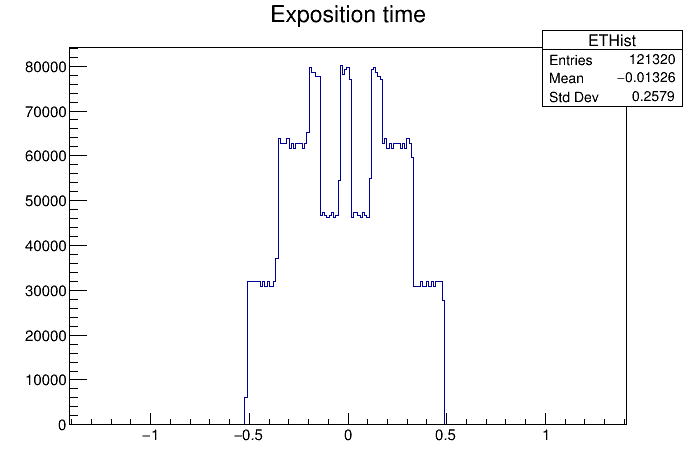

In [12]:
ETC = ROOT.TCanvas()

#ETHist.Draw('COLZ')
ETHist.Draw('HIST')
#ETC.SetLogy()
ETC.Draw()

In [13]:
ALPIDE_norm=np.zeros(ETHist.GetNbinsX()+1)

for i in range(ETHist.GetNbinsX()+1):
    ALPIDE_norm[i]=ETHist.GetBinContent(i)

# Analysis with normalization (time and Strobe parameters)

In [14]:
th_max
#int(301*(-1.3)/(th_max-th_min)+150)

1.41

In [15]:
#normalization array from -180° to 180° [steps]
#ALPIDE_norm=np.zeros(201)
Data_folder="Data"

Run_Analysis = True
Force_Analysis = False

#load files of a cartain dataset
files=os.listdir(Data_folder + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)
        if name.startswith(exp_setup):
        #if name.startswith("center_alpide"):
        #if name.startswith("gold_alpide_3_SC_10m"):
            #for gold_ files
            #angle=int(name.split('_')[1])*(1 if name.split('_')[2]=='DC' else -1)
            # for gold_alpide files
            angle=int(name.split('_')[2])*(1 if name.split('_')[3]=='DC' else -1)

            #os.system("python Packet_analyzer.py -f " + name + " -p -b 1000 -s %i -w %f" % (angle,weight))
            root_file=Path("Analyzed_Data/"+name+"/"+name+".root")
            root_file_existence_flag=root_file.is_file()
            if (Run_Analysis and not root_file_existence_flag) or Force_Analysis:
                Args = "-Df "+Data_folder+" -f "+name+" -p -A DB -NThr "+N_Threads+" -d 3 15 -s %i"%(angle)
                %run 'Packet_analyzer.py' {Args}
                #%run 'Packet_analyzer-Copy2.py' {Args}
            

100%|██████████| 495/495 [00:00<00:00, 168754.00it/s]


In [18]:
#merge all the TTree
if exp_setup=='gold_alpide':
    ! $ROOTSYS/bin/hadd -f Tot_data_tree/Tot_ALPIDE_53SC_87DC_gold.root Analyzed_Data/gold_alpide*/*.root
elif exp_setup=='tin_alpide':
    ! $ROOTSYS/bin/hadd -f Tot_data_tree/Tot_ALPIDE_53SC_47DC_tin.root Analyzed_Data/tin_alpide*/*.root
elif exp_setup=='center_alpide':
    ! $ROOTSYS/bin/hadd -f Tot_data_tree/Tot_center_3SC_37DC_test.root Analyzed_Data/center_alpide*/*.root 
    
#! $ROOTSYS/bin/hadd -f Tot_data_tree/Tree_0.root Analyzed_Data/gold_alpide_17_DC_5m*/*.root
#! $ROOTSYS/bin/hadd -f Tot_data_tree/Tot_center_3SC_37DC_test.root Analyzed_Data/center_alpide*/*.root 


hadd Target file: Tot_data_tree/Tot_center_3SC_37DC_test.root
hadd compression setting for all output: 1
hadd Source file 1: Analyzed_Data/center_alpide_17_DC_5m_run10_170121/center_alpide_17_DC_5m_run10_170121.root
hadd Source file 2: Analyzed_Data/center_alpide_17_DC_5m_run11_170121/center_alpide_17_DC_5m_run11_170121.root
hadd Source file 3: Analyzed_Data/center_alpide_17_DC_5m_run1_170121/center_alpide_17_DC_5m_run1_170121.root
hadd Source file 4: Analyzed_Data/center_alpide_17_DC_5m_run12_170121/center_alpide_17_DC_5m_run12_170121.root
hadd Source file 5: Analyzed_Data/center_alpide_17_DC_5m_run13_170121/center_alpide_17_DC_5m_run13_170121.root
hadd Source file 6: Analyzed_Data/center_alpide_17_DC_5m_run14_170121/center_alpide_17_DC_5m_run14_170121.root
hadd Source file 7: Analyzed_Data/center_alpide_17_DC_5m_run15_170121/center_alpide_17_DC_5m_run15_170121.root
hadd Source file 8: Analyzed_Data/center_alpide_17_DC_5m_run16_170121/center_alpide_17_DC_5m_run16_170121.root
hadd Sour

In [19]:
#ROOT.enableJSVis()
ROOT.disableJSVis()

#convert the TTree in np arrays
if exp_setup=='gold_alpide':
    root_file  =ROOT.TFile.Open("Tot_data_tree/Tot_Alide_53SC_87DC_test.root")
elif exp_setup=='tin_alpide':
    root_file  =ROOT.TFile.Open("Tot_data_tree/Tot_ALPIDE_53SC_47DC_tin.root")
elif exp_setup=='center_alpide':
    root_file  =ROOT.TFile.Open("Tot_data_tree/Tot_center_3SC_37DC_test.root")
#root_file_1  =ROOT.TFile.Open("Tot_data_tree/Tot_center_3SC_37DC_test.root")
#root_file_1  =ROOT.TFile.Open("Tot_data_tree/Tree_20.root")
Data_tree    = root_file.Get("tree")
#Data_tree.Print()

Noise_points = Data_tree.AsMatrix(['Rnoise'])
Areas        = Data_tree.AsMatrix(['Rareas'])
Means        = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Theta        = Data_tree.AsMatrix(['Rtheta'])
#Weight       = Data_tree.AsMatrix(['Rweight'])
Exptime      = Data_tree.AsMatrix(['Reetime'])
Ratios       = Data_tree.AsMatrix(['Rratios'])

501.1161154341241 257.38806256086446


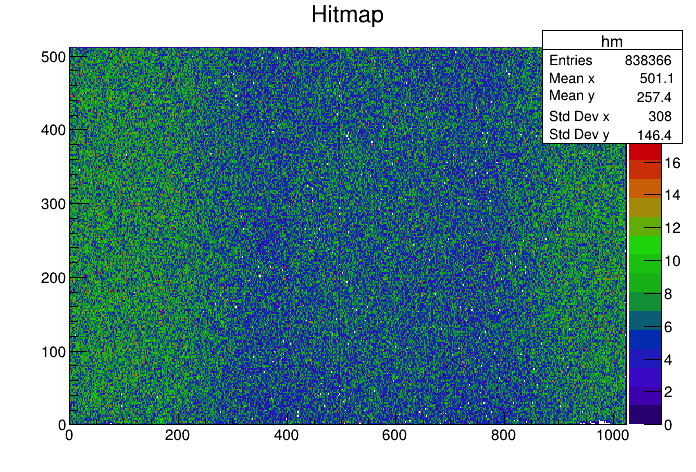

In [20]:
hm = ROOT.TH2D('hm','Hitmap',512,0,1024,256,0,512)

for coordinate in Means:
    hm.Fill(coordinate[0],coordinate[1])
    
ROOT.gStyle.SetPalette(107)
    
HC=ROOT.TCanvas()
hm.Draw('COLZ')
HC.Draw()

print(np.mean(Means[:,0]), np.mean(Means[:,1]))

Info in <TCanvas::Print>: pdf file Area_Histo.pdf has been created
Info in <TCanvas::Print>: pdf file PCA_Ratio_Histo.pdf has been created


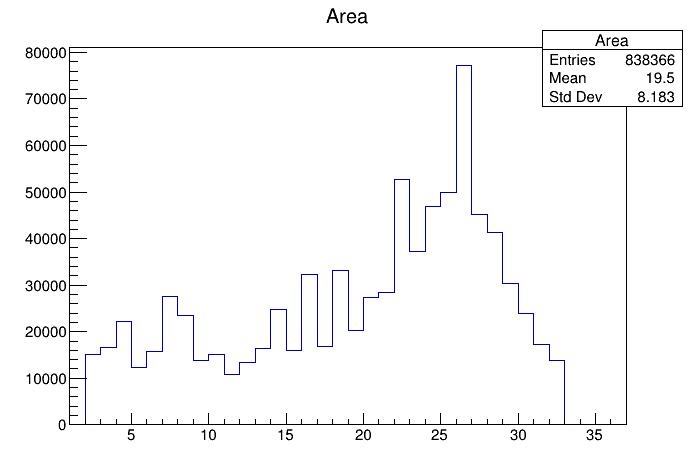

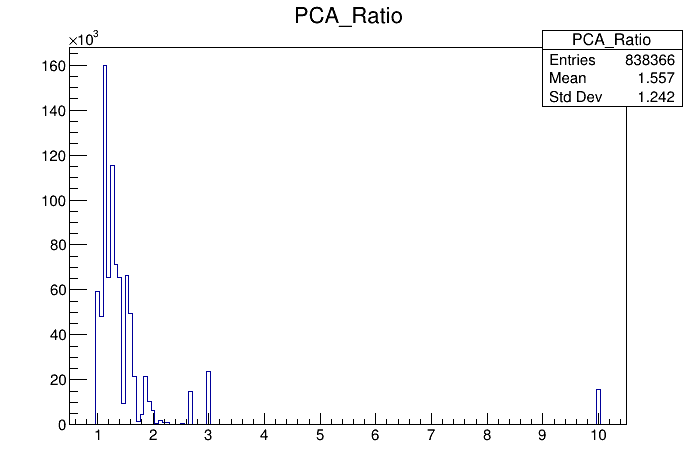

In [21]:
ar_max=int(np.amax(Areas))
ar_max=37
nbins=int((ar_max-1))
ArHist,AC=make_histo(Areas,'Area',nbins,1,ar_max)
AC.Draw()

r_max=(np.amax(Ratios)+0.5)
nbins=150
RHist,RC=make_histo(Ratios,'PCA_Ratio',nbins,0.5,r_max)
RC.Draw()

In [22]:
Area_thr=12
Ratio_thr=4.5

mask_thr =  np.logical_and (np.squeeze(Areas)      > Area_thr, np.squeeze(Ratios)     < Ratio_thr)
mask_x   =  np.logical_and (np.squeeze(Means[:,0]) > xmin    , np.squeeze(Means[:,0]) < xmax     )
mask_y   =  np.logical_and (np.squeeze(Means[:,1]) > ymin    , np.squeeze(Means[:,1]) < ymax     )

mask = np.logical_and(mask_thr, np.logical_and(mask_x, mask_y))


Areas_disc  = Areas [mask]
Means_disc  = Means [mask]
Theta_disc  = Theta [mask]
#Weight_disc = Weight[mask]
Exptime_disc= Exptime[mask]
Ratios_disc = Ratios[mask]


#A_disc_index = np.where  (Areas<Area_thr)
#Areas_disc   = np.delete (Areas ,A_disc_index)
#Means_disc   = np.delete (Means ,A_disc_index,axis=0)
#Theta_disc   = np.delete (Theta ,A_disc_index)
#Weight_disc  = np.delete (Weight,A_disc_index)
#Ratios_disc  = np.delete (Ratios,A_disc_index)

#R_disc_index=np.where (Ratios_disc>Ratio_thr)
#Areas_disc  =np.delete(Areas_disc,R_disc_index)
#Means_disc  =np.delete(Means_disc,R_disc_index,axis=0)
#Theta_disc  =np.delete(Theta_disc,R_disc_index)
#Weight_disc =np.delete(Weight_disc,R_disc_index)
#Ratios_disc =np.delete(Ratios_disc,R_disc_index)

In [23]:
ALPIDE_norm[12]

0.0

In [24]:
#t_max = (np.amax(Exptime_disc))
#t_min = (np.amin(Exptime_disc))
#nbins  = 10
#th_max = (np.amax(Theta_disc))
#th_min = (np.amin(Theta_disc))
#thbins=600
#
#ETHist = ROOT.TH1F('ThHist', 'Theta weighted',thbins,th_min,th_max)
##ETHist = ROOT.TH2F('ThHist', 'Theta weighted',nbins,t_min,t_max,800,th_min,th_max)
#
#for value,time in zip(Theta_disc,Exptime_disc):
#    #ThHist.Fill(value,weight/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
#    ETHist.Fill(value,time)
#    #ThHist.Fill(value,weight)
#    
#ETHist.SetStats(False)
#    
#ETC = ROOT.TCanvas()
#
##ETHist.Draw('COLZ')
#ETHist.Draw('HIST')
##ETC.SetLogy()
#ETC.Draw()
#TC.Print('Graph_images/Theta_histo.png')

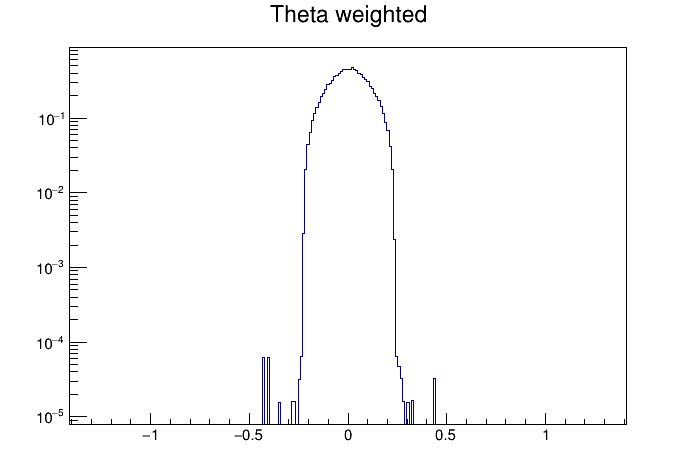

In [25]:
ThHist = ROOT.TH1F('ThHist', 'Theta weighted',thbins,th_min,th_max)


for value in Theta_disc:
    #ThHist.Fill(value,weight/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
    #ThHist.Fill(value-center*np.pi/180)
    ThHist.Fill(value)
    
CountHist=ThHist.Clone()
    
ThHist.Divide(ThHist,ETHist)
    
ThHist.SetStats(False)
    
TC = ROOT.TCanvas()

ThHist.Draw('HIST')
TC.SetLogy()
TC.Draw()
#TC.Print('Graph_images/Theta_histo.png')

In [26]:
center_hratio = []
counts_hratio = []
ALPIDE_ev_err    = []
ALPIDE_t      = []
ALPIDE_ev     = []
ALPIDE_r_err = []

for i in range(ThHist.GetNbinsX()):
    center_hratio.append(ThHist.GetBinCenter (i+1))
    counts_hratio.append(ThHist.GetBinContent(i+1))
    ALPIDE_r_err.append(ThHist.GetBinError(i+1))
ALPIDE_r_err = np.array(ALPIDE_r_err)
    
for i in range(ETHist.GetNbinsX()):
    ALPIDE_t.append(ETHist.GetBinContent(i+1))
ALPIDE_t = np.array(ALPIDE_t)
    
    
for i in range(CountHist.GetNbinsX()):
    if ETHist.GetBinContent(i+1)!=0:
        value=np.sqrt(CountHist.GetBinContent(i+1))/ETHist.GetBinContent(i+1)
    else:
        value=0
    ALPIDE_ev_err.append(value)
    ALPIDE_ev.append(CountHist.GetBinContent(i+1))
ALPIDE_ev_err = np.array(ALPIDE_ev_err)
ALPIDE_ev     = np.array(ALPIDE_ev)
 
    
center_hratio = np.array(center_hratio)*180/(np.pi)
counts_hratio = np.array(counts_hratio)

# Find profile center

Profile center=0.140°


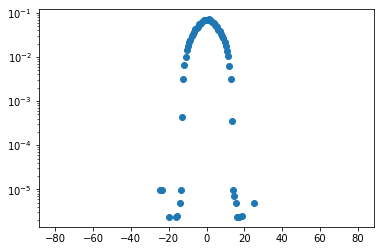

In [27]:
from scipy.optimize import curve_fit


def parabola(x, a, b, c):
    return a*x**2+b*x+c


popt, pcov = curve_fit(parabola, center_hratio, counts_hratio)
center     = -popt[1]/(2*popt[0])

print('Profile center=%1.3f°' % center)

center_hratio = center_hratio - center

norm = np.sum(counts_hratio)*(center_hratio[1]-center_hratio[0])
counts_hratio_norm = counts_hratio/norm

plt.plot(center_hratio, counts_hratio_norm, 'o')
plt.yscale('log')

## Mask count equal to zeros

In [36]:
if exp_setup=='center_alpide':
    mask_zeros = np.greater(counts_hratio, np.zeros(len(counts_hratio)))
else:
    mask_zeros = np.greater(counts_hratio, np.zeros(len(counts_hratio)))

## Save as data frame

In [37]:
d = {
    "ALPIDE_step"    : center_hratio[mask_zeros]/0.9,
    "ALPIDE_rad"     : center_hratio[mask_zeros]*(np.pi)/(180),
    "ALPIDE_deg"     : center_hratio[mask_zeros],
    "ALPIDE_ev"      : counts_hratio[mask_zeros]*ALPIDE_t[mask_zeros],
    "ALPIDE_t"       : ALPIDE_t[mask_zeros],
    "ALPIDE_r"       : counts_hratio[mask_zeros]* 3600, #ev/h
    "ALPIDE_ev_err"  : ALPIDE_ev_err[mask_zeros],
    "ALPIDE_r_err"   : ALPIDE_r_err[mask_zeros] * 3600
    
}

df = pd.DataFrame(data=d)
if exp_setup=='gold_alpide':
    df.to_csv('../../../plots/data/ALPIDE/ALPIDE_data_gold.csv',index=False)
elif exp_setup=='tin_alpide':
    df.to_csv('../../../plots/data/ALPIDE/ALPIDE_data_tin.csv',index=False)
elif exp_setup=='center_alpide':
    df.to_csv('../../../plots/data/ALPIDE/ALPIDE_data_profile.csv',index=False)    


In [30]:
from scipy.optimize import curve_fit

def parabola(x, a, b, c):
    return a*x**2+b*x+c

alpide_data   = []
alpide_weight = []

for value in Theta_disc:
    alpide_data.append(value*180/np.pi)
    #alpide_weight.append(1/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
    alpide_weight.append(1/ALPIDE_norm[int((thbins+1)*(value)/(th_max-th_min)+thbins/2)+1])
    
alpide_data   = np.array(alpide_data  )
alpide_weight = np.array(alpide_weight)

alpide_data_centered=alpide_data-center

Warning in <TFile::Append>: Replacing existing TH1: ThHist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ThHist (Potential memory leak).


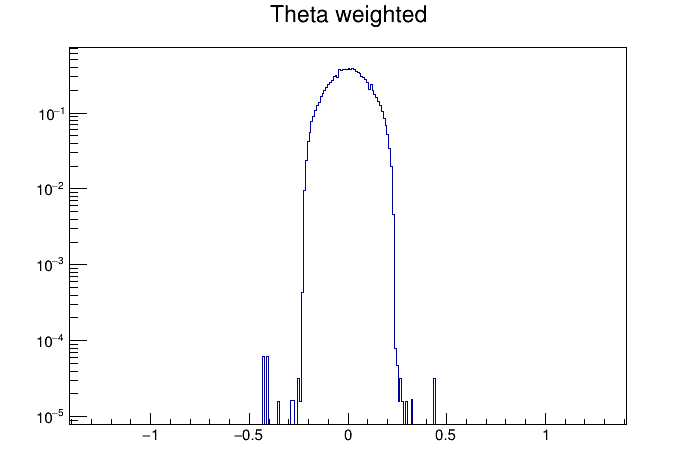

In [31]:
nbins  = 300

ThHist = ROOT.TH1F('ThHist', 'Theta weighted',nbins,th_min,th_max)


for value in Theta_disc:
    #ThHist.Fill(value,weight/(ALPIDE_norm[int(value*180/(np.pi)/0.9+100)]))
    ThHist.Fill(value-center*np.pi/180,1/(ALPIDE_norm[int((thbins+1)*(value)/(th_max-th_min)+thbins/2)+1]))
    #ThHist.Fill(value,weight)
    
ThHist.SetStats(False)
    
TC = ROOT.TCanvas()

ThHist.Draw('HIST')
TC.SetLogy()
TC.Draw()
#TC.Print('Graph_images/Theta_histo.png')

In [ ]:
ar_max = int(np.amax(Areas_disc))
nbins  = int(ar_max)

ArHist,AC=make_histo(Areas_disc,'Area',nbins,1,ar_max+1)
AC.Draw()
AC.Print('Area_histo.png')

r_max   = np.amax(Ratios_disc)
nbins   = 100


RHist,RC=make_histo(Ratios_disc,'Ratios',nbins,0.95,r_max+0.05)
RHist.Draw()
RC.Draw()


#MxHist = ROOT.TH1F('MxHist', 'X Means',16,0,1023)
#
#for value in Means_disc[:,0]:
#    MxHist.Fill(value)
#
#MxC=ROOT.TCanvas()
#MxHist.Draw()
#MxC.Draw()

## Compare with simulation

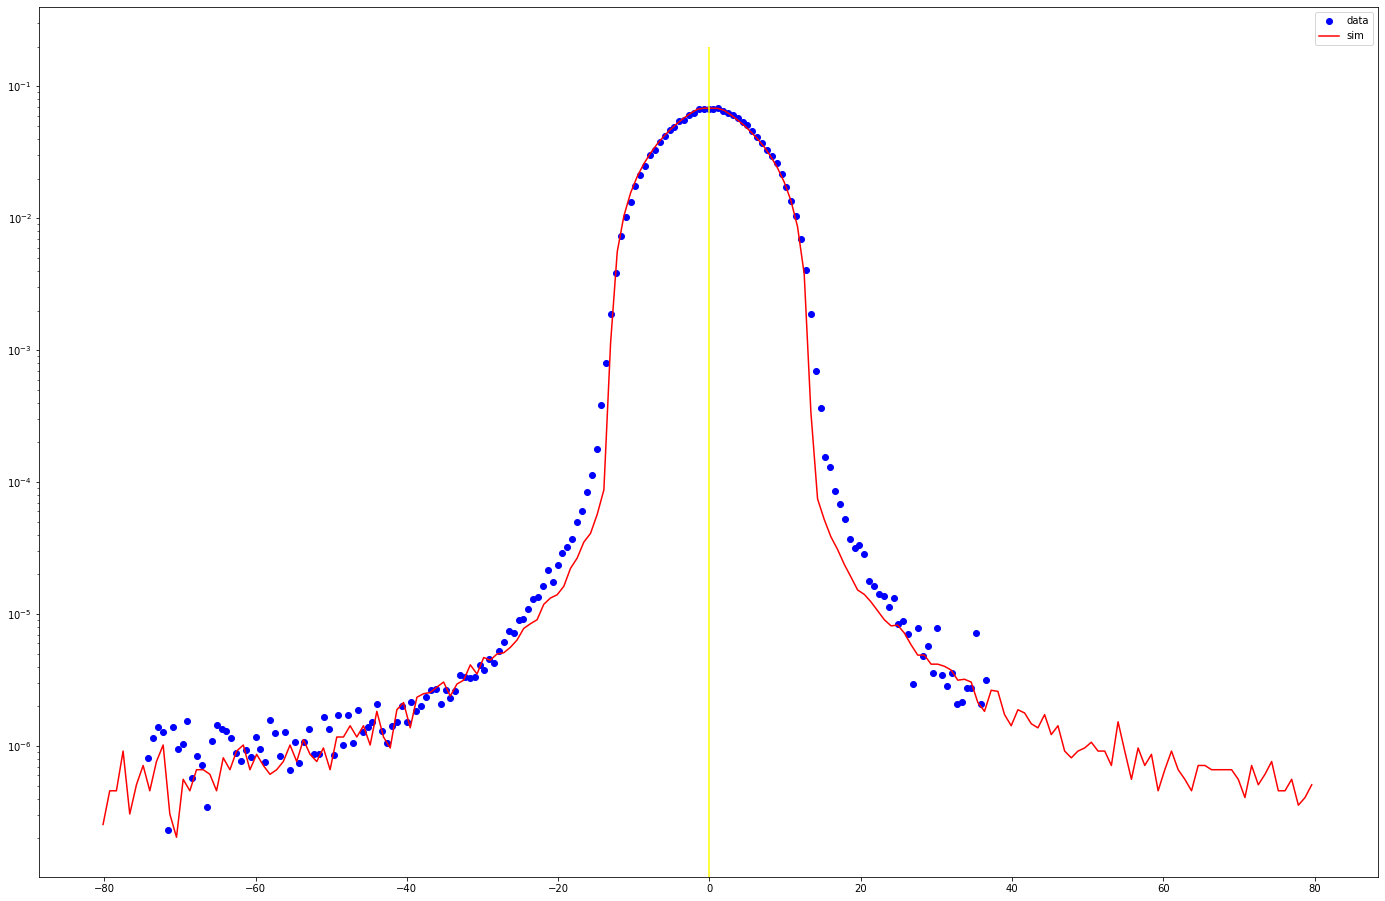

In [34]:
#alpide_sim= np.loadtxt("../../../simulations/notebook/final_sim/ALPIDE_gold_beam.txt")
alpide_sim= np.loadtxt("../../../simulations/notebook/final_sim/ALPIDE_sim2(1).txt")
#alpide_sim= np.loadtxt("../../../simulations/notebook/final_sim/ALPIDE_beam_profile.txt")
alpide_sim= alpide_sim[np.logical_and(alpide_sim[:,0]>min(center_hratio),alpide_sim[:,0]<max(center_hratio))]

norm = np.sum(alpide_sim)*(alpide_sim[1,0]-alpide_sim[0,0])
#norm_data = np.sum(counts_histo_bello)*(center_histo_bello[1]-center_histo_bello[0])

plt.figure(figsize=(24,16))
plt.plot(center_hratio, counts_hratio_norm, 'o', color='blue', label='data')
#plt.hist(alpide_data_centered, weights=alpide_weight, bins=len(alpide_sim), density=True, label="data")
#plt.scatter(alpide_sim[:,0]+x_mean, alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
plt.plot(alpide_sim[:,0], alpide_sim[:,1]/norm, '-', color='red', zorder=1000, label="sim")
plt.vlines(0,0,0.2, color='yellow', zorder=10000)
#plt.xlim(-15,15)
plt.yscale("log")
plt.legend()
plt.savefig('Alpide_profile.pdf')
plt.show()
#np.savetxt("ALPIDE_data_profile.txt", np.column_stack((center_hratio,counts_hratio_norm)))
np.savetxt("ALPIDE_data_gold.txt", np.column_stack((center_hratio,counts_hratio_norm)))


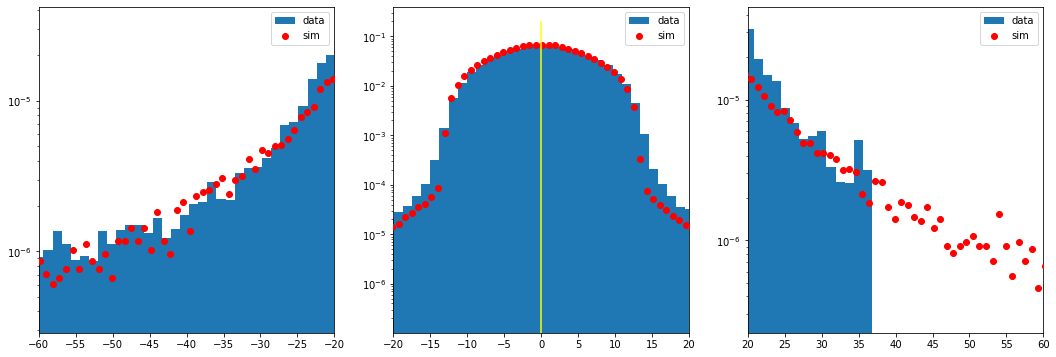

In [35]:
fig, axs = plt.subplots(1,3, figsize=(18, 6))


axs[0].hist(alpide_data_centered, weights=alpide_weight, bins=90, density=True, label="data")
axs[0].scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
axs[0].set_xlim(-60,-20)
axs[0].set_ylim(alpide_sim[np.argmin(abs(-60-alpide_sim[:,0])), 1]/3/norm,
                alpide_sim[np.argmin(abs(-20-alpide_sim[:,0])), 1]*3/norm)
axs[0].set_yscale("log")
axs[0].legend()

axs[1].hist(alpide_data_centered, weights=alpide_weight, bins=90, density=True, label="data")
axs[1].scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
axs[1].vlines(0,0,0.2, color='yellow', zorder=10000)
axs[1].set_xlim(-20,20)
axs[1].set_yscale("log")
axs[1].legend()

axs[2].hist(alpide_data_centered, weights=alpide_weight, bins=90, density=True, label="data")
axs[2].scatter(alpide_sim[:,0], alpide_sim[:,1]/norm, color='red', zorder=1000, label="sim")
axs[2].set_xlim(20,60)
axs[2].set_ylim(alpide_sim[np.argmin(abs(60-alpide_sim[:,0])), 1]/3/norm,
                alpide_sim[np.argmin(abs(20-alpide_sim[:,0])), 1]*3/norm)
axs[2].set_yscale("log")
axs[2].legend()

# X-Y area mapping

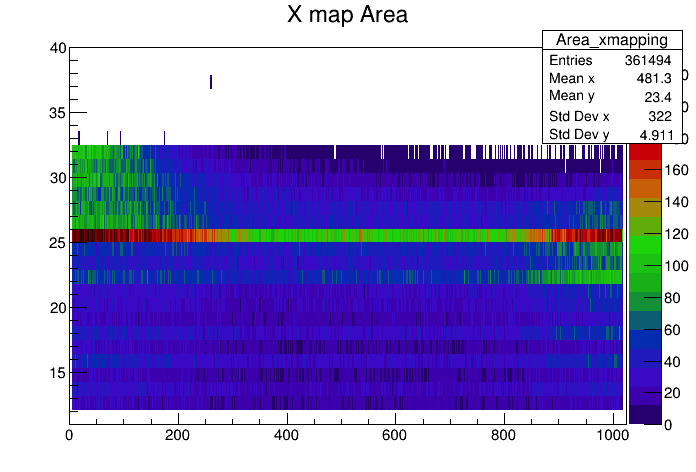

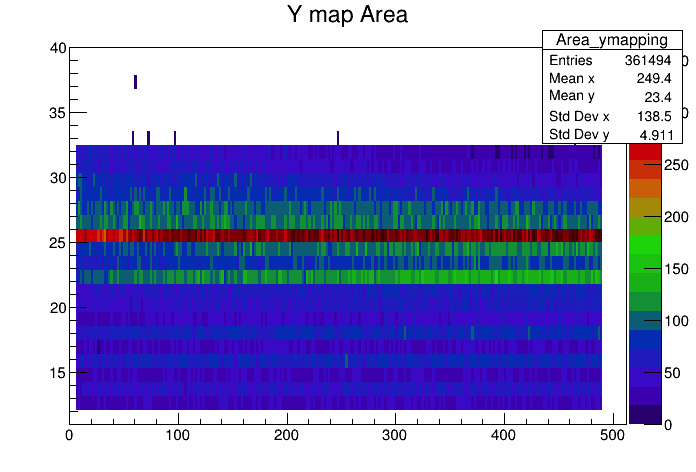

In [36]:
#ROOT.enableJSVis()
ROOT.disableJSVis()

Area_nbins=40-Area_thr-1

Area_xmapping = ROOT.TH2D('Area_xmapping','X map Area',512,0,1024,Area_nbins,Area_thr-1,40)

for coordinate,Area in zip(Means_disc,Areas_disc):
    Area_xmapping.Fill(coordinate[0],Area)
    
ROOT.gStyle.SetPalette(107)
    
HAXM=ROOT.TCanvas()
Area_xmapping.Draw('COLZ')
HAXM.Draw()

Area_ymapping = ROOT.TH2D('Area_ymapping','Y map Area',256,0,512,Area_nbins,Area_thr-1,40)

for coordinate,Area in zip(Means_disc,Areas_disc):
    Area_ymapping.Fill(coordinate[1],Area)
    
ROOT.gStyle.SetPalette(107)
    
HAYM=ROOT.TCanvas()
Area_ymapping.Draw('COLZ')
HAYM.Draw()


# Theta area mapping

<ipython-input-37-bce0b67eef79>:19: RuntimeWarning: divide by zero encountered in double_scalars
  Area_thmapping_nd.Fill(value*180/np.pi-center,Area,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))


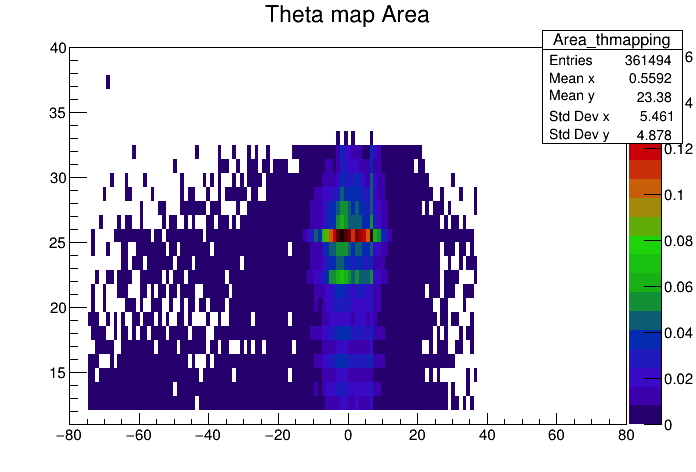

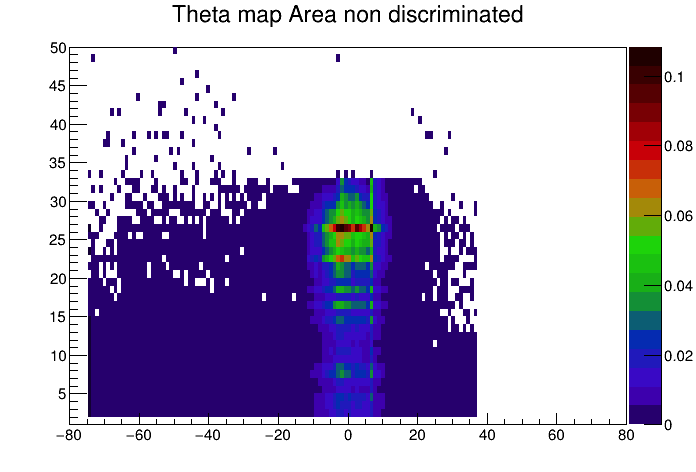

In [37]:
Area_nbins=40-Area_thr-1
nbins_theta=150

Area_thmapping = ROOT.TH2D('Area_thmapping','Theta map Area',nbins_theta,-80,80,Area_nbins,Area_thr-1,40)

for value,Area in zip(Theta_disc,Areas_disc):
    Area_thmapping.Fill(value*180/np.pi-center,Area,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
    
HATHM=ROOT.TCanvas()
Area_thmapping.Draw('COLZ')
#HATHM.SetLogz()
HATHM.Draw()

Area_thmapping_nd = ROOT.TH2D('Area_thmapping_nd','Theta map Area non discriminated',nbins_theta,-80,80,49,1,50)

for value,Area in zip(Theta,Areas):
    Area_thmapping_nd.Fill(value*180/np.pi-center,Area,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
Area_thmapping_nd.SetStats(False)
    
HATHMND=ROOT.TCanvas()
Area_thmapping_nd.Draw('COLZ')
HATHMND.Draw()



<ipython-input-38-ede5ca6b93f1>:18: RuntimeWarning: divide by zero encountered in double_scalars
  PCAr_thmapping_nd.Fill(value*180/np.pi-center,PCAr,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))


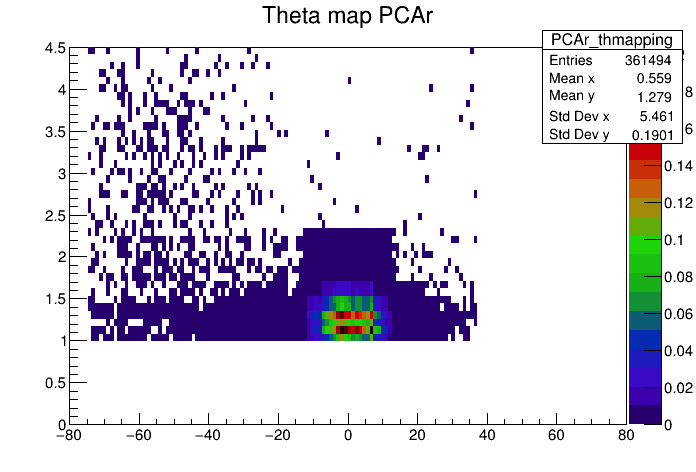

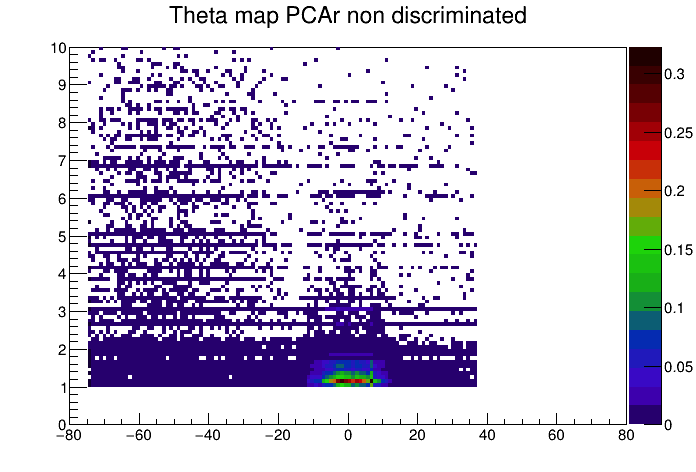

In [38]:
PCAr_nbins=50
nbins_theta=150

PCAr_thmapping = ROOT.TH2D('PCAr_thmapping','Theta map PCAr',nbins_theta,-80,80,PCAr_nbins,0,Ratio_thr)

for value,PCAr in zip(Theta_disc,Ratios_disc):
    PCAr_thmapping.Fill(value*180/np.pi-center/180,PCAr,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
    
HPrTHM=ROOT.TCanvas()
PCAr_thmapping.Draw('COLZ')
HPrTHM.Draw()

PCAr_thmapping_nd = ROOT.TH2D('PCAr_thmapping_nd','Theta map PCAr non discriminated',nbins_theta,-80,80,2*PCAr_nbins,0,10)

for value,PCAr in zip(Theta,Ratios):
    PCAr_thmapping_nd.Fill(value*180/np.pi-center,PCAr,1/(ALPIDE_norm[int((thbins)*(value)/(th_max-th_min)+thbins/2)]))
    
ROOT.gStyle.SetPalette(107)
PCAr_thmapping_nd.SetStats(False)
    
HPrTHMND=ROOT.TCanvas()
PCAr_thmapping_nd.Draw('COLZ')
#HPrTHMND.SetLogz()
HPrTHMND.Draw()